In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/kaggle"

In [0]:
# %cd /content/gdrive/My Drive/kaggle
# %pwd

In [0]:
# ! kaggle datasets download -d paramaggarwal/fashion-product-images-small

In [0]:
# %cd ~

In [0]:
!unzip "/content/gdrive/My Drive/kaggle/fashion-product-images-small.zip"

Streaming output truncated to the last 5000 lines.
  inflating: myntradataset/images/58131.jpg  
  inflating: myntradataset/images/58132.jpg  
  inflating: myntradataset/images/58133.jpg  
  inflating: myntradataset/images/58135.jpg  
  inflating: myntradataset/images/58136.jpg  
  inflating: myntradataset/images/58137.jpg  
  inflating: myntradataset/images/58138.jpg  
  inflating: myntradataset/images/58139.jpg  
  inflating: myntradataset/images/5814.jpg  
  inflating: myntradataset/images/58140.jpg  
  inflating: myntradataset/images/58141.jpg  
  inflating: myntradataset/images/58143.jpg  
  inflating: myntradataset/images/58144.jpg  
  inflating: myntradataset/images/58145.jpg  
  inflating: myntradataset/images/58146.jpg  
  inflating: myntradataset/images/58147.jpg  
  inflating: myntradataset/images/58148.jpg  
  inflating: myntradataset/images/58149.jpg  
  inflating: myntradataset/images/5815.jpg  
  inflating: myntradataset/images/58150.jpg  
  inflating: myntradataset/imag

In [0]:
%ls

gdrive/  images/  myntradataset/  sample_data/  styles.csv


In [0]:
%rm -r images
%rm styles.csv

In [0]:
%ls

gdrive/  myntradataset/  sample_data/


### Clean and filter metadata

In [0]:
import numpy as np
import pandas as pd
import os

base_path = "myntradataset/"
old_csv_path = os.path.join(base_path, "styles.csv")
csv_path = os.path.join(base_path, "styles_fixed.csv")
img_path = os.path.join(base_path, "images")

In [0]:
# Fixing bad lines in csv file (due to commas in product names)

import csv

with open(old_csv_path) as rf, open(csv_path, 'w') as wf:
    csv_reader = csv.reader(rf, delimiter=',')
    csv_writer = csv.writer(wf, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for row in csv_reader:
        if len(row) > 10:
            save_row = row[:8]
            save_row.append(','.join(row[9:]))
        else:
            save_row = row
        csv_writer.writerow(save_row)

In [0]:
# %cp myntradataset/styles_fixed.csv "/content/gdrive/My Drive/kaggle/fashion-product-images-small/styles_fixed.csv"

In [0]:
styles = pd.read_csv(csv_path)

In [0]:
styles['image'] = styles.apply(lambda row: str(row['id']) + ".jpg", axis=1)
print(styles['image'])

0        15970.jpg
1        39386.jpg
2        59263.jpg
3        21379.jpg
4        53759.jpg
           ...    
44441    17036.jpg
44442     6461.jpg
44443    18842.jpg
44444    46694.jpg
44445    51623.jpg
Name: image, Length: 44446, dtype: object


In [0]:
for image in styles['image']:
    if not os.path.exists(os.path.join(img_path, image)):
        print("Image {} doesn't exist!".format(image))

Image 39403.jpg doesn't exist!
Image 39410.jpg doesn't exist!
Image 39401.jpg doesn't exist!
Image 39425.jpg doesn't exist!
Image 12347.jpg doesn't exist!


In [0]:
# Filer out rows for which images don't exist
img_exists = styles.apply(lambda row: os.path.exists(os.path.join(img_path, row['image'])), axis=1)

styles = styles[img_exists]
print(styles)

          id gender  ...                               productDisplayName      image
0      15970    Men  ...                 Turtle Check Men Navy Blue Shirt  15970.jpg
1      39386    Men  ...               Peter England Men Party Blue Jeans  39386.jpg
2      59263  Women  ...                         Titan Women Silver Watch  59263.jpg
3      21379    Men  ...    Manchester United Men Solid Black Track Pants  21379.jpg
4      53759    Men  ...                            Puma Men Grey T-shirt  53759.jpg
...      ...    ...  ...                                              ...        ...
44441  17036    Men  ...                        Gas Men Caddy Casual Shoe  17036.jpg
44442   6461    Men  ...               Lotto Men's Soccer Track Flip Flop   6461.jpg
44443  18842    Men  ...             Puma Men Graphic Stellar Blue Tshirt  18842.jpg
44444  46694  Women  ...                   Rasasi Women Blue Lady Perfume  46694.jpg
44445  51623  Women  ...  Fossil Women Pink Dial Chronograph Watc

### Create train-test splits

In [0]:
# Place images from even-numbered years in train-split and odd-numbered years in test-split

is_train = styles['year']%2==0
is_test = styles['year']%2!=0

full_train = styles[is_train]
print(full_train.shape)

full_test = styles[is_test]
print(full_test.shape)

(23787, 11)
(20654, 11)


### Sub-split training data for pre-training and fine-tuning

In [0]:
# Find the top-20 classes in the training split

top_articleType = styles.groupby('articleType').size().sort_values(ascending=False).head(20).reset_index()

print("Top 20 classes:")
print(top_articleType)

Top 20 classes:
              articleType     0
0                 Tshirts  7069
1                  Shirts  3215
2            Casual Shoes  2846
3                 Watches  2542
4            Sports Shoes  2036
5                  Kurtas  1844
6                    Tops  1762
7                Handbags  1759
8                   Heels  1323
9              Sunglasses  1073
10                Wallets   936
11             Flip Flops   916
12                Sandals   897
13                 Briefs   849
14                  Belts   813
15              Backpacks   724
16                  Socks   686
17           Formal Shoes   637
18  Perfume and Body Mist   614
19                  Jeans   608


In [0]:
total_classes = len(styles['articleType'].unique())
rest_classes = total_classes - 20

rest_articleType = styles.groupby('articleType').size().sort_values(ascending=True).head(rest_classes).reset_index()

print("Remaining {} classes:".format(rest_classes))
print(rest_articleType)

Remaining 122 classes:
             articleType    0
0                   Ipad    1
1         Hair Accessory    1
2         Cushion Covers    1
3      Mens Grooming Kit    1
4    Body Wash and Scrub    1
..                   ...  ...
117              Dresses  464
118                  Bra  477
119                Flats  500
120             Trousers  530
121               Shorts  547

[122 rows x 2 columns]


In [0]:
# Covert the datatype of column containing articleType to categorical

top_articleType['articleType'] = top_articleType['articleType'].astype('category')
rest_articleType['articleType'] = rest_articleType['articleType'].astype('category')

In [0]:
classmap_top20 = dict(zip(top_articleType['articleType'], top_articleType['articleType'].cat.codes))
classmap_ft = dict(zip(rest_articleType['articleType'], rest_articleType['articleType'].cat.codes))

In [0]:
inv_classmap_top20 = {v: k for k, v in classmap_top20.items()}
inv_classmap_ft = {v: k for k, v in classmap_ft.items()}

In [0]:
# Check if there is any intersection between top-20 and remaining values

print(len(set(classmap_ft.keys()).intersection(set(classmap_top20.keys()))))

0


In [0]:
# Pick the rows corresponding to the top-20 classes for pretraining and corresponding testing

filter_topArticles = full_train['articleType'].isin(top_articleType['articleType'])
train_top20_data = full_train[filter_topArticles]
print(train_top20_data.shape)

filter_topArticles_test = full_test['articleType'].isin(top_articleType['articleType'])
test_top20_data = full_test[filter_topArticles_test]
print(test_top20_data.shape)

(18000, 11)
(15149, 11)


In [0]:
# Pick the rows corresponding to the rest of the classes for fine-tuning and corresponding testing

train_ft_data = full_train[~filter_topArticles]
print(train_ft_data.shape)

test_ft_data = full_test[~filter_topArticles_test]
print(test_ft_data.shape)

(5787, 11)
(5505, 11)


In [0]:
print(len(train_top20_data['articleType'].unique()))
print(len(train_ft_data['articleType'].unique()))
print(len(full_train['articleType'].unique()))

19
88
107


In [0]:
print(len(test_top20_data['articleType'].unique()))
print(len(test_ft_data['articleType'].unique()))
print(len(full_test['articleType'].unique()))

20
102
122


In [0]:
# Check if there is any class overlap between train-top20 and fine-tune data (should be 0)

print(len(set(train_top20_data['articleType'].unique()).intersection(set(train_ft_data['articleType'].unique()))))
print(len(set(test_top20_data['articleType'].unique()).intersection(set(test_ft_data['articleType'].unique()))))

0
0


In [0]:
from sklearn.model_selection import train_test_split

train_top20_data, val_top20_data = train_test_split(train_top20_data, test_size=0.2)
train_ft_data, val_ft_data = train_test_split(train_ft_data, test_size=0.2)

In [0]:
print(len(train_top20_data), len(val_top20_data))
print(len(train_ft_data), len(val_ft_data))

14400 3600
4629 1158


In [0]:
data_map = {'train_top20': train_top20_data,
            'val_top20': val_top20_data,
            'train_ft': train_ft_data,
            'val_ft': val_ft_data,
            'test_top20': test_top20_data,
            'test_ft': test_ft_data}

data_top20_map = {
    'train': train_top20_data,
    'val': val_top20_data,
    'test': test_top20_data
}

data_ft_map = {
    'train': train_ft_data,
    'val': val_ft_data,
    'test': test_ft_data
}

### Load Dataset

In [0]:
import torch
import torchvision
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from PIL import Image

class FashionDatasetSmall(Dataset):
    """
    Custom dataset class that uses metadata stored in a DataFrame and returns
    the actual data: (x,y) = (img, label) -
        img is a Tensor representing the image
        label is the categorical label corresponding to the articleType
    """
    def __init__(self, df, img_path, class_map, data_transforms=None):
        """
        Args:
            df (DataFrame): pandas DataFrame containing the metadata
            img_path (string): path to the folder where images are
            data_transforms: pytorch transforms transformations
        """
        self.image_arr = np.asarray(df['image'].values)
        self.label_arr = np.asarray(df['articleType'].values)
        self.to_tensor = transforms.ToTensor()
        self.img_path = img_path
        self.class_map = class_map
        self.data_transforms = data_transforms

    def __getitem__(self, index):
        try:
            img_name = self.image_arr[index]
            img_as_img = Image.open(os.path.join(self.img_path, img_name))
            if img_as_img.mode != 'RGB':
                img_as_img = img_as_img.convert('RGB')

            if self.data_transforms is not None:
                img_as_tensor = self.data_transforms(img_as_img)
            else:
                img_as_tensor = self.to_tensor(img_as_img)

            label = self.class_map[self.label_arr[index]]
        except Exception as e:
            print("Exception while trying to fetch item at index",index)
            print("Image =",img_name)
            raise e

        return (img_as_tensor, label)

    def __len__(self):
        return len(self.image_arr)

In [0]:
# Data augmentation and normalization for training and fine-tuning
# Just normalization for test data

train_transforms = [
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]

test_transforms = [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]

val_transforms = test_transforms

data_transforms = {}
for key in data_top20_map.keys():
    if 'train' in key:
        data_transforms[key] = transforms.Compose(train_transforms)
    elif 'val' in key:
        data_transforms[key] = transforms.Compose(val_transforms)
    else:
        data_transforms[key] = transforms.Compose(test_transforms)

datasets_top20 = {x: FashionDatasetSmall(data_top20_map[x], img_path,
                                         classmap_top20, data_transforms[x]) 
            for x in data_top20_map.keys()}

for name, dataset in datasets_top20.items():
    print("Created {} dataset with {} samples".format(name, len(dataset)))

Created train dataset with 14400 samples
Created val dataset with 3600 samples
Created test dataset with 15149 samples


In [0]:
from torch.utils.data import DataLoader

dataloaders_top20 = {x: DataLoader(datasets_top20[x], batch_size=64,
                             shuffle=False, num_workers=1)
              for x in data_top20_map.keys()}

In [0]:
verify_datasets = False

if verify_datasets:
    for name, dataloader in dataloaders_top20.items():
        print("Verifying dataloader for {}".format(name))
        for item in tqdm(dataloader):
            pass

In [0]:
# Adapted from: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

import time
import copy
from tqdm.notebook import tqdm
from collections import defaultdict

SAVE_PATH = '/content/gdrive/My Drive/kaggle/fashion-product-images-small/ckpts'
CKPT_PATH = os.path.join(SAVE_PATH, 'best_val_top20.ckpt')
CKPT_PATH_FT = os.path.join(SAVE_PATH, 'best_val_ft.ckpt')

def train_model(model, criterion, optimizer, data_loaders, scheduler=None,
                num_epochs=10, lock_weights=False, load_acc=0., CKPT_PATH=CKPT_PATH):
    if lock_weights==True:
        for param in model.parameters():
            param.requires_grad = False

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    history = {'train': defaultdict(list), 'val': defaultdict(list)}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            print('Iterating through data for phase: {}...'.format(phase))

            for inputs, labels in tqdm(data_loaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device).long()

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train' and scheduler is not None:
                scheduler.step()

            epoch_loss = current_loss / len(data_loaders[phase].dataset)
            epoch_acc = current_corrects.double() / len(data_loaders[phase].dataset)

            history[phase]['loss'].append(epoch_loss)
            history[phase]['acc'].append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                # Check if the current best model is better than the loaded model
                if best_acc > load_acc:
                    print('--Saving checkpoint--')
                    # Save checkpont file
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': best_model_wts,
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': epoch_loss,
                        'acc': epoch_acc
                    }, CKPT_PATH)

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)

    return model, history

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Training on top-20 classes

In [0]:
from torchvision import models
import torch.nn as nn
import torch
import torch.optim as optim

resnet = models.resnet50(pretrained=True)

In [0]:
# Modify the final fully connected layer for our dataset

num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, len(classmap_top20))

print(resnet.fc)

Linear(in_features=2048, out_features=20, bias=True)


In [0]:
# Estimate class weights to handle imbalance

def get_class_weights(df, classmap, eps=1):
    """
    Returns class weights corresponding to each class using the formula:
        weights = n_samples / (n_classes * (np.bincount(y)+eps))
    'eps' is added to handle classes that don't have any samples
    """
    labels = [classmap[x] for x in df['articleType']]
    labels_count = np.bincount(labels) + eps
    return len(labels) / (len(classmap) * labels_count)

weights_top20 = get_class_weights(data_top20_map['train'], classmap_top20)
print(weights_top20)

[3.61809045e+00 1.79104478e+00 1.36105860e+00 5.76923077e-01
 1.78217822e+00 2.50000000e+00 9.00000000e-01 1.16129032e+00
 2.67657993e+00 7.88608981e-01 7.20000000e+02 1.87500000e+00
 8.03571429e-01 1.81818182e+00 1.01265823e+00 8.68516285e-01
 8.62275449e-01 3.25497288e-01 1.48453608e+00 3.60180090e-01]


In [0]:
from torch.optim import lr_scheduler

criterion = nn.CrossEntropyLoss(weight=torch.Tensor(weights_top20).to(device))

optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

load_flag = True

# Load previous checkpoint if it exists
if load_flag and os.path.exists(CKPT_PATH):
    checkpoint = torch.load(CKPT_PATH)
    resnet.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    load_acc = checkpoint['acc']
    print("Loaded previous checkpoint trained on {} epoch(s) with final loss={:.4f}, acc={:.4f}".format(epoch+1, loss, load_acc))
else:
    load_acc = 0.

In [0]:
resnet = resnet.to(device)

In [0]:
resnet, history = train_model(resnet, criterion, optimizer, dataloaders_top20,
                     num_epochs=25, scheduler=scheduler, load_acc=load_acc)

Epoch 0/24
----------
Iterating through data for phase: train...



train Loss: 1.3239 Acc: 0.6124
Iterating through data for phase: val...



val Loss: 0.3888 Acc: 0.8525
--Saving checkpoint--

Epoch 1/24
----------
Iterating through data for phase: train...



train Loss: 0.5475 Acc: 0.8015
Iterating through data for phase: val...



val Loss: 0.2845 Acc: 0.8811
--Saving checkpoint--

Epoch 2/24
----------
Iterating through data for phase: train...



train Loss: 0.4440 Acc: 0.8358
Iterating through data for phase: val...



val Loss: 0.2535 Acc: 0.8925
--Saving checkpoint--

Epoch 3/24
----------
Iterating through data for phase: train...



train Loss: 0.4001 Acc: 0.8510
Iterating through data for phase: val...



val Loss: 0.2182 Acc: 0.9139
--Saving checkpoint--

Epoch 4/24
----------
Iterating through data for phase: train...



train Loss: 0.3586 Acc: 0.8622
Iterating through data for phase: val...



val Loss: 0.1955 Acc: 0.9206
--Saving checkpoint--

Epoch 5/24
----------
Iterating through data for phase: train...



train Loss: 0.3219 Acc: 0.8760
Iterating through data for phase: val...



val Loss: 0.1830 Acc: 0.9256
--Saving checkpoint--

Epoch 6/24
----------
Iterating through data for phase: train...



train Loss: 0.3078 Acc: 0.8832
Iterating through data for phase: val...



val Loss: 0.1791 Acc: 0.9303
--Saving checkpoint--

Epoch 7/24
----------
Iterating through data for phase: train...



train Loss: 0.2999 Acc: 0.8802
Iterating through data for phase: val...



val Loss: 0.1791 Acc: 0.9286

Epoch 8/24
----------
Iterating through data for phase: train...



train Loss: 0.3062 Acc: 0.8830
Iterating through data for phase: val...



val Loss: 0.1755 Acc: 0.9311
--Saving checkpoint--

Epoch 9/24
----------
Iterating through data for phase: train...



train Loss: 0.2970 Acc: 0.8872
Iterating through data for phase: val...



val Loss: 0.1737 Acc: 0.9308

Epoch 10/24
----------
Iterating through data for phase: train...



train Loss: 0.2865 Acc: 0.8888
Iterating through data for phase: val...



val Loss: 0.1739 Acc: 0.9311

Epoch 11/24
----------
Iterating through data for phase: train...



train Loss: 0.2972 Acc: 0.8886
Iterating through data for phase: val...



val Loss: 0.1746 Acc: 0.9317
--Saving checkpoint--

Epoch 12/24
----------
Iterating through data for phase: train...



train Loss: 0.2924 Acc: 0.8869
Iterating through data for phase: val...



val Loss: 0.1737 Acc: 0.9311

Epoch 13/24
----------
Iterating through data for phase: train...



train Loss: 0.2882 Acc: 0.8887
Iterating through data for phase: val...



val Loss: 0.1750 Acc: 0.9317

Epoch 14/24
----------
Iterating through data for phase: train...



train Loss: 0.2916 Acc: 0.8891
Iterating through data for phase: val...



val Loss: 0.1732 Acc: 0.9319
--Saving checkpoint--

Epoch 15/24
----------
Iterating through data for phase: train...



train Loss: 0.2898 Acc: 0.8846
Iterating through data for phase: val...



val Loss: 0.1749 Acc: 0.9306

Epoch 16/24
----------
Iterating through data for phase: train...



train Loss: 0.2944 Acc: 0.8900
Iterating through data for phase: val...



val Loss: 0.1751 Acc: 0.9319

Epoch 17/24
----------
Iterating through data for phase: train...



train Loss: 0.2984 Acc: 0.8857
Iterating through data for phase: val...



val Loss: 0.1755 Acc: 0.9311

Epoch 18/24
----------
Iterating through data for phase: train...



train Loss: 0.2962 Acc: 0.8881
Iterating through data for phase: val...



val Loss: 0.1741 Acc: 0.9311

Epoch 19/24
----------
Iterating through data for phase: train...



train Loss: 0.2956 Acc: 0.8868
Iterating through data for phase: val...



val Loss: 0.1742 Acc: 0.9306

Epoch 20/24
----------
Iterating through data for phase: train...



train Loss: 0.3049 Acc: 0.8838
Iterating through data for phase: val...



val Loss: 0.1751 Acc: 0.9308

Epoch 21/24
----------
Iterating through data for phase: train...



train Loss: 0.2875 Acc: 0.8885
Iterating through data for phase: val...



val Loss: 0.1745 Acc: 0.9317

Epoch 22/24
----------
Iterating through data for phase: train...



train Loss: 0.2858 Acc: 0.8922
Iterating through data for phase: val...



val Loss: 0.1748 Acc: 0.9306

Epoch 23/24
----------
Iterating through data for phase: train...



train Loss: 0.2783 Acc: 0.8928
Iterating through data for phase: val...



val Loss: 0.1749 Acc: 0.9308

Epoch 24/24
----------
Iterating through data for phase: train...



train Loss: 0.2879 Acc: 0.8885
Iterating through data for phase: val...



val Loss: 0.1747 Acc: 0.9311

Training complete in 36m 18s
Best val Acc: 0.931944


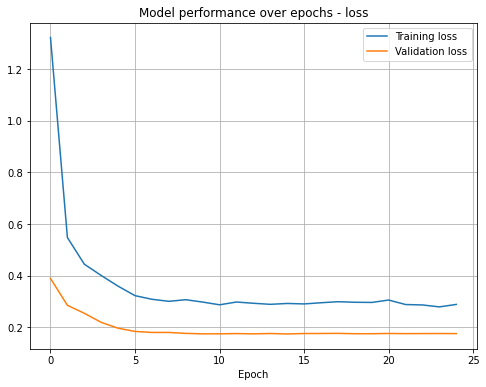

In [0]:
import matplotlib.pyplot as plt

%matplotlib inline

def plot_perf(history, metric='loss'):
    fig, ax = plt.subplots(figsize = (8,6))
    ax.grid()
    ax.set_title("Model performance over epochs - {}".format(metric))
    ax.set_xlabel("Epoch")
    ax.plot(history['train'][metric], label="Training {}".format(metric))
    ax.plot(history['val'][metric], label="Validation {}".format(metric))
    ax.legend()
    plt.show()

plot_perf(history, 'loss')

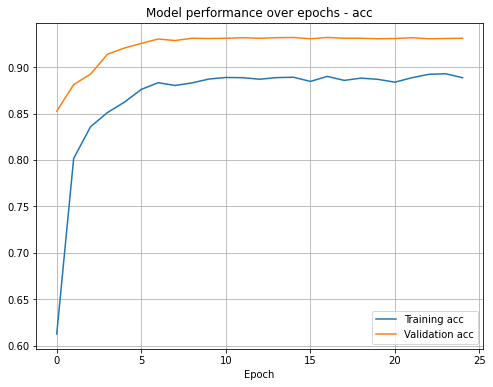

In [0]:
plot_perf(history, 'acc')

In [0]:
# torch.cuda.empty_cache()

In [0]:
def get_accuracy(model, dataloader, topk=(1,5)):
    """
    Computes the class-wise and average (micro) accuracy@k
    for the specified values of k
    """
    dataset = dataloader.dataset
    total = len(dataset)
    maxk = max(topk)
    correct_count = {k: 0 for k in topk}

    n_classes = len(dataloader.dataset.class_map)
    class_correct_count = {k: np.array([0 for n in range(n_classes)]) for k in topk}

    all_labels = np.array([dataset.class_map[x] for x in dataset.label_arr])
    class_totals = np.bincount(all_labels)
    # Handle missing classes
    class_totals[class_totals==0] = -1

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images = images.to(device)
            labels = labels.to(device).long()
            outputs = model(images)
            _, pred = torch.topk(outputs, maxk, 1)
            pred = pred.t()
            correct = pred.eq(labels.view(1, -1).expand_as(pred))
            for k in topk:
                # See if the label is present any of the top k predictions
                for cp, cl in zip(pred.t(), labels):
                    if cl in cp[:k]:
                        class_correct_count[k][cl] += 1
                # Sum up correct predictions for current batch
                correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
                correct_count[k] += correct_k
    
    avg_acc = {k: v.item()/total for k, v in correct_count.items()}
    class_acc = {k: v/class_totals for k, v in class_correct_count.items()}

    # Reset accuracy for missing classes to 1
    for k_acc in class_acc.values():
        k_acc[class_totals==-1] = 1.

    return avg_acc, class_acc

In [0]:
avg_acc, class_acc = get_accuracy(resnet, dataloaders_top20['test'])

print("Test accuracy: Top-1 = {}, Top-5 = {}".format(avg_acc[1], avg_acc[5]))

In [0]:
def generate_acc_df(avg_acc, class_acc, inv_map):
    df = pd.DataFrame(class_acc,
                      index=[inv_map[i] for i in range(len(inv_map))])

    avg_df = pd.DataFrame(avg_acc, index=['Average (Micro)'])
    df = pd.concat([avg_df, df])

    df = df.rename(columns={1: 'Top-1', 5: 'Top-5'})
    df *= 100
    df = df.round(2)

    return df

In [0]:
accuracy_df = generate_acc_df(avg_acc, class_acc, inv_classmap_top20)
accuracy_df

,Top-1,Top-5
Average,86.72,95.74
Backpacks,97.69,100.00
Belts,99.07,99.07
Briefs,96.26,100.00
Casual Shoes,76.53,99.61
Flip Flops,86.52,97.79
Formal Shoes,97.84,99.64
Handbags,96.02,99.87
Heels,88.14,99.82
Jeans,98.89,98.89


### Training on fine-tune set

In [0]:
datasets_ft = {x: FashionDatasetSmall(data_ft_map[x], img_path,
                                         classmap_ft, data_transforms[x]) 
            for x in data_ft_map.keys()}

for name, dataset in datasets_ft.items():
    print("Created {} dataset with {} samples".format(name, len(dataset)))

Created train dataset with 4629 samples
Created val dataset with 1158 samples
Created test dataset with 5505 samples


In [0]:
dataloaders_ft = {x: DataLoader(datasets_ft[x], batch_size=64,
                             shuffle=False, num_workers=1)
              for x in data_ft_map.keys()}

In [0]:
verify_datasets = True

if verify_datasets:
    for name, dataloader in dataloaders_ft.items():
        print("Verifying dataloader for {}".format(name))
        for item in tqdm(dataloader):
            pass


Verifying dataloader for train




Verifying dataloader for val




Verifying dataloader for test


In [0]:
# Modify the final fully connected layer for our dataset

print(resnet.fc)

resnet_ft = resnet

num_features = resnet.fc.in_features
resnet_ft.fc = nn.Linear(num_features, len(classmap_ft))

print(resnet_ft.fc)

Linear(in_features=2048, out_features=122, bias=True)
Linear(in_features=2048, out_features=122, bias=True)


In [0]:
# Estimate class weights to handle imbalance

weights_ft = get_class_weights(data_ft_map['train'], classmap_ft)
print(weights_ft.shape)

(122,)


In [0]:
criterion_ft = nn.CrossEntropyLoss(weight=torch.Tensor(weights_ft).to(device))

# optimizer_ft = optim.Adam(resnet_ft.parameters(), eps=1e-07)

optimizer_ft = optim.SGD(resnet_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
scheduler_ft = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

load_flag = False

# Load previous checkpoint if it exists
if load_flag and os.path.exists(CKPT_PATH_FT):
    checkpoint = torch.load(CKPT_PATH_FT)
    resnet_ft.load_state_dict(checkpoint['model_state_dict'])
    optimizer_ft.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    load_acc = checkpoint['acc']
    print("Loaded previous checkpoint trained on {} epoch(s) with final loss={:.4f}, acc={:.4f}".format(epoch+1, loss, load_acc))
else:
    load_acc = 0.

In [0]:
resnet_ft = resnet_ft.to(device)

In [0]:
resnet_ft, history = train_model(resnet_ft, criterion_ft, optimizer_ft,
                                 dataloaders_ft, num_epochs=40, scheduler=scheduler_ft,
                                 load_acc=load_acc, CKPT_PATH=CKPT_PATH_FT)

Epoch 0/39
----------
Iterating through data for phase: train...



train Loss: 3.9142 Acc: 0.1529
Iterating through data for phase: val...



val Loss: 2.9924 Acc: 0.4231
--Saving checkpoint--

Epoch 1/39
----------
Iterating through data for phase: train...



train Loss: 2.6589 Acc: 0.3891
Iterating through data for phase: val...



val Loss: 2.4056 Acc: 0.5190
--Saving checkpoint--

Epoch 2/39
----------
Iterating through data for phase: train...



train Loss: 2.1131 Acc: 0.4802
Iterating through data for phase: val...



val Loss: 2.1401 Acc: 0.5501
--Saving checkpoint--

Epoch 3/39
----------
Iterating through data for phase: train...



train Loss: 1.8031 Acc: 0.5349
Iterating through data for phase: val...



val Loss: 1.9788 Acc: 0.6045
--Saving checkpoint--

Epoch 4/39
----------
Iterating through data for phase: train...



train Loss: 1.5264 Acc: 0.5729
Iterating through data for phase: val...



val Loss: 1.8333 Acc: 0.6140
--Saving checkpoint--

Epoch 5/39
----------
Iterating through data for phase: train...



train Loss: 1.3563 Acc: 0.5941
Iterating through data for phase: val...



val Loss: 1.7502 Acc: 0.6701
--Saving checkpoint--

Epoch 6/39
----------
Iterating through data for phase: train...



train Loss: 1.2755 Acc: 0.6245
Iterating through data for phase: val...



val Loss: 1.7121 Acc: 0.6900
--Saving checkpoint--

Epoch 7/39
----------
Iterating through data for phase: train...



train Loss: 1.2038 Acc: 0.6343
Iterating through data for phase: val...



val Loss: 1.6981 Acc: 0.7038
--Saving checkpoint--

Epoch 8/39
----------
Iterating through data for phase: train...



train Loss: 1.1750 Acc: 0.6451
Iterating through data for phase: val...



val Loss: 1.6865 Acc: 0.7055
--Saving checkpoint--

Epoch 9/39
----------
Iterating through data for phase: train...



train Loss: 1.1563 Acc: 0.6477
Iterating through data for phase: val...



val Loss: 1.6705 Acc: 0.7124
--Saving checkpoint--

Epoch 10/39
----------
Iterating through data for phase: train...



train Loss: 1.1712 Acc: 0.6548
Iterating through data for phase: val...



val Loss: 1.6755 Acc: 0.7142
--Saving checkpoint--

Epoch 11/39
----------
Iterating through data for phase: train...



train Loss: 1.1621 Acc: 0.6384
Iterating through data for phase: val...



val Loss: 1.6727 Acc: 0.7150
--Saving checkpoint--

Epoch 12/39
----------
Iterating through data for phase: train...



train Loss: 1.1449 Acc: 0.6461
Iterating through data for phase: val...



val Loss: 1.6719 Acc: 0.7124

Epoch 13/39
----------
Iterating through data for phase: train...



train Loss: 1.1486 Acc: 0.6518
Iterating through data for phase: val...



val Loss: 1.6706 Acc: 0.7107

Epoch 14/39
----------
Iterating through data for phase: train...



train Loss: 1.1400 Acc: 0.6474
Iterating through data for phase: val...



val Loss: 1.6656 Acc: 0.7090

Epoch 15/39
----------
Iterating through data for phase: train...



train Loss: 1.1451 Acc: 0.6513
Iterating through data for phase: val...



val Loss: 1.6705 Acc: 0.7159
--Saving checkpoint--

Epoch 16/39
----------
Iterating through data for phase: train...



train Loss: 1.1498 Acc: 0.6418
Iterating through data for phase: val...



val Loss: 1.6674 Acc: 0.7142

Epoch 17/39
----------
Iterating through data for phase: train...



train Loss: 1.1001 Acc: 0.6556
Iterating through data for phase: val...



val Loss: 1.6643 Acc: 0.7116

Epoch 18/39
----------
Iterating through data for phase: train...



train Loss: 1.1713 Acc: 0.6470
Iterating through data for phase: val...



val Loss: 1.6650 Acc: 0.7150

Epoch 19/39
----------
Iterating through data for phase: train...



train Loss: 1.1859 Acc: 0.6589
Iterating through data for phase: val...



val Loss: 1.6647 Acc: 0.7150

Epoch 20/39
----------
Iterating through data for phase: train...



train Loss: 1.1690 Acc: 0.6524
Iterating through data for phase: val...



val Loss: 1.6682 Acc: 0.7142

Epoch 21/39
----------
Iterating through data for phase: train...



train Loss: 1.1241 Acc: 0.6522
Iterating through data for phase: val...



val Loss: 1.6704 Acc: 0.7133

Epoch 22/39
----------
Iterating through data for phase: train...



train Loss: 1.1262 Acc: 0.6427
Iterating through data for phase: val...



val Loss: 1.6639 Acc: 0.7124

Epoch 23/39
----------
Iterating through data for phase: train...



train Loss: 1.1158 Acc: 0.6606
Iterating through data for phase: val...



val Loss: 1.6662 Acc: 0.7133

Epoch 24/39
----------
Iterating through data for phase: train...



train Loss: 1.1687 Acc: 0.6509
Iterating through data for phase: val...



val Loss: 1.6659 Acc: 0.7168
--Saving checkpoint--

Epoch 25/39
----------
Iterating through data for phase: train...



train Loss: 1.1334 Acc: 0.6582
Iterating through data for phase: val...



val Loss: 1.6712 Acc: 0.7142

Epoch 26/39
----------
Iterating through data for phase: train...



train Loss: 1.1974 Acc: 0.6451
Iterating through data for phase: val...



val Loss: 1.6636 Acc: 0.7133

Epoch 27/39
----------
Iterating through data for phase: train...



train Loss: 1.1465 Acc: 0.6552
Iterating through data for phase: val...



val Loss: 1.6638 Acc: 0.7176
--Saving checkpoint--

Epoch 28/39
----------
Iterating through data for phase: train...



train Loss: 1.1287 Acc: 0.6505
Iterating through data for phase: val...



val Loss: 1.6600 Acc: 0.7150

Epoch 29/39
----------
Iterating through data for phase: train...



train Loss: 1.1514 Acc: 0.6427
Iterating through data for phase: val...



val Loss: 1.6684 Acc: 0.7124

Epoch 30/39
----------
Iterating through data for phase: train...



train Loss: 1.1579 Acc: 0.6496
Iterating through data for phase: val...



val Loss: 1.6651 Acc: 0.7107

Epoch 31/39
----------
Iterating through data for phase: train...



train Loss: 1.1452 Acc: 0.6535
Iterating through data for phase: val...



val Loss: 1.6632 Acc: 0.7133

Epoch 32/39
----------
Iterating through data for phase: train...



train Loss: 1.1324 Acc: 0.6451
Iterating through data for phase: val...



val Loss: 1.6661 Acc: 0.7133

Epoch 33/39
----------
Iterating through data for phase: train...



train Loss: 1.1694 Acc: 0.6552
Iterating through data for phase: val...



val Loss: 1.6630 Acc: 0.7159

Epoch 34/39
----------
Iterating through data for phase: train...



train Loss: 1.1912 Acc: 0.6453
Iterating through data for phase: val...



val Loss: 1.6651 Acc: 0.7107

Epoch 35/39
----------
Iterating through data for phase: train...



train Loss: 1.1399 Acc: 0.6602
Iterating through data for phase: val...



val Loss: 1.6682 Acc: 0.7133

Epoch 36/39
----------
Iterating through data for phase: train...



train Loss: 1.1566 Acc: 0.6472
Iterating through data for phase: val...



val Loss: 1.6615 Acc: 0.7098

Epoch 37/39
----------
Iterating through data for phase: train...



train Loss: 1.1580 Acc: 0.6544
Iterating through data for phase: val...



val Loss: 1.6669 Acc: 0.7124

Epoch 38/39
----------
Iterating through data for phase: train...



train Loss: 1.1519 Acc: 0.6533
Iterating through data for phase: val...



val Loss: 1.6640 Acc: 0.7124

Epoch 39/39
----------
Iterating through data for phase: train...



train Loss: 1.1532 Acc: 0.6518
Iterating through data for phase: val...



val Loss: 1.6575 Acc: 0.7142

Training complete in 19m 5s
Best val Acc: 0.717617


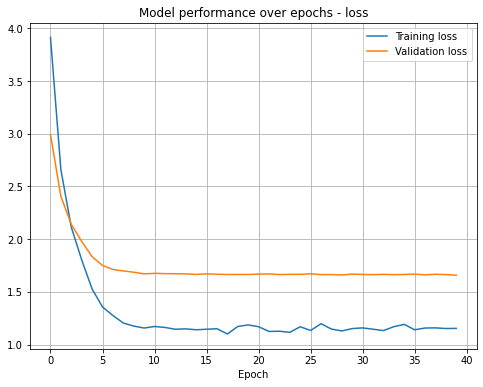

In [0]:
plot_perf(history, 'loss')

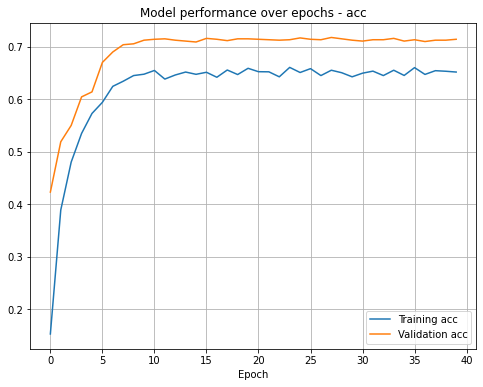

In [0]:
plot_perf(history, 'acc')

In [338]:
avg_acc, class_acc = get_accuracy(resnet_ft, dataloaders_ft['test'])

print("Test accuracy: Top-1 = {}, Top-5 = {}".format(avg_acc[1], avg_acc[5]))


Test accuracy: Top-1 = 0.4103542234332425, Top-5 = 0.6232515894641235


In [0]:
accuracy_df_ft = generate_acc_df(avg_acc, class_acc, inv_classmap_ft)

In [340]:
accuracy_df_ft

,Top-1,Top-5
Average (Micro),41.04,62.33
Accessory Gift Set,100.00,100.00
Baby Dolls,0.00,0.00
Bangle,13.04,73.91
Basketballs,72.73,100.00
...,...,...
Umbrellas,100.00,100.00
Waist Pouch,15.38,69.23
Waistcoat,0.00,50.00
Water Bottle,100.00,100.00


In [345]:
print(accuracy_df_ft.to_markdown())

|                           |   Top-1 |   Top-5 |
|:--------------------------|--------:|--------:|
| Average (Micro)           |   41.04 |   62.33 |
| Accessory Gift Set        |  100    |  100    |
| Baby Dolls                |    0    |    0    |
| Bangle                    |   13.04 |   73.91 |
| Basketballs               |   72.73 |  100    |
| Bath Robe                 |    0    |    0    |
| Beauty Accessory          |    0    |    0    |
| Blazers                   |  100    |  100    |
| Body Lotion               |    0    |    0    |
| Body Wash and Scrub       |    0    |    0    |
| Booties                   |  100    |  100    |
| Boxers                    |  100    |  100    |
| Bra                       |   93.01 |   98.78 |
| Bracelet                  |   90.48 |  100    |
| Camisoles                 |   32.35 |   79.41 |
| Capris                    |   26.92 |   96.15 |
| Caps                      |   90.84 |   95.42 |
| Churidar                  |   50    |   75    |
